In [ ]:
import numpy as np
from numpy.random import randn, randint

from keras.datasets import mnist, fashion_mnist
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
import matplotlib.pyplot as plt

Using TensorFlow backend.


The main differences between a WGAN and a normal GAN are the following:
  - We are using a linear activation in the output layer of the critic model, instead of a sigmoid
  - Use -1 and 1 labels for real and fake images, instead of 1 and 0
  - Use wasserstein loss to train the generator and critic
  - Constrain critic model weights to a limited range after each mini batch update. For example: [-0.01, 0.01]
  - Update the critic model more times than the generator each iteration
  - Use RMSProp version of gradient descent with a small learnning rate






  

First thing we are going to do is to create a class for clipping weight.

This is a class that must extend the Constraint class and define an implementation of the __call__() function for applying the operation.

We can also define an __init__() function to set the configuration, in this case, the symmetrical size of the bounding box for the weight hypercube, e.g. 0.01.

Let's define it now.

In [ ]:
class ClipConstraint(Constraint):
	def __init__(self, clip_value):
		self.clip_value = clip_value

	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

The next step is to define the wasserstein loss.

In [ ]:
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

We can now define the models. The critic model takes as an input a grayscale image and returns a score for the realness or fakeness of that image.

The critic model uses the ClipConstraint weight constraint to clip model weights after mini-batch updates.

It is optimized using the wasserstein_loss() function, that we will create later.

In [ ]:
def create_crit(inp=(28,28,1)):
	init = RandomNormal(stddev=0.02) # Initialize weights
	const = ClipConstraint(0.01) # Clip weight

	model = Sequential()
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=inp))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dense(1))

	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

Now we can define our generator. The generator takes as an input a point in the latent space and it outputs a single 28x28 grayscaled image. 


In [ ]:
def create_gen(latent_dim):
	init = RandomNormal(stddev=0.02) # Initialize weights
	model = Sequential()

	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())	
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())	
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

The GAN model can be defined as a combination of the generative and critic model into a larger model.

The GAN model can be used to train the model weights in the generator using the error and output calculated from the critic model. Because the critic model is trained separately, the weights are marked as not trainable. 

The GAN model takes as an input a point in a latent space, uses the generator to generate an image, which is later pushed into the critic model which is outputing a score. This score represents if the image is fake or real.

In [ ]:
def create_gan(generator, critic):
	critic.trainable = False # Make weights not trainable

	model = Sequential()
	model.add(generator)
	model.add(critic)

	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

We will need training data, for this reason we are going to create a helper function which will load the data. We are using the handrwitten digits dataset.

We are selecting only the data which represents the number 5, it consists of 5000 samples. We are doing this in order to have our model train more quickly. 

Remember, our data needs to be in the range of [-1, 1], so we are going to reshape it.

In [ ]:
def load_dataset(dataset):
	(trainX, _), (_, _) = dataset.load_data()
 
	X = np.expand_dims(trainX, axis=-1) # Expand to 3d, e.g. add channels

	X = X.astype('float32')
	X = (X - 127.5) / 127.5 # Scale from [0,255] to [-1,1]
	return X

We will require one batch of real images from the dataset each update to the GAN model. We can achieve this by selecting a random sample of images from the dataset. 

Let's create a helper function which will select and return a random sample of images from the dataset and their corresponding labels, tthey are going to be -1 because they indicate real images.

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples) # Select random samples
	X = dataset[ix]
  
	y = -np.ones((n_samples, 1)) # Create labels
	return X, y

We also need the latent points for the generator model. 
Our helper function "generate_latent_points", takes as an input the size of the latent space and how many points we need, will return us a batch of input samples.

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
 
	x_input = x_input.reshape(n_samples, latent_dim) # Reshape into batch of inputs
	return x_input

These points we generated using the function will be used as an input to the generator function, which will generate new images. 

The function that we will create next will implement this. It will also create labels equal to 1, which indicate that they are fake or generated.

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) # Generate points

	X = generator.predict(x_input)
	y = np.ones((n_samples, 1)) # Create labels
	return X, y

We will need to record the performance of our WGAN. The best way to do this is to generate images and then review and evaluate them.

Let's create a helper function which will use the generator model at a certain training epoch to generate 100 images.

In [ ]:
def summarize_performance(step, gen_model, latent_dim, n_samples=100):
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples) # Create fake images
	X = (X + 1) / 2.0 # Scale them from [-1, 1] to [0, 1]

	for i in range(10 * 10):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap=plt.cm.gray)
	
	f_name = f'generated_images_{step+1}.png'
	plt.savefig(f_name)

	plt.close()
	# save the generator model
	f_name1 = f'model_{step+1}.h5'
	gen_model.save(f_name1)
	print(f'Save -> {f_name} and {f_name1}')

Also a good idea is to keep track of the loss and accuracy of the model.

We can track both losses and accuracies of the generative and critic model. Let's create a helper function which will visualize this.

In [ ]:
def plot_history(crit_real_hist, crit_fake_hist, gen_hist):
	# plot history
	plt.plot(crit_real_hist, label='crit_real')
	plt.plot(crit_fake_hist, label='crit_fake')
	plt.plot(gen_hist, label='gen')
	plt.legend()
	plt.show()
	plt.savefig('plot_line_plot_loss.png')
	plt.close()

Now, we are ready to train our WGAN.

Our model is going to be trained for 10 epochs of 97 batches, which will equal to 970 iterations.

The critic model is updated for a half batch of real samples, then a half batch of fake samples, creating one whole batch. Then it is repeated n_critic times.

The generator is then updated. One important thing is that the label is set to -1 or real for the generated images. This is important for the generator to get better at generating real looking samples.

The performance of the critic and generator model will be shown. We are also saving the images generated at every epoch, also the line plots of the models performance.

In [ ]:
def train(gen_model, crit_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	batch_per_epoch = int(dataset.shape[0] / n_batch) # Number of batches per epoch
	n_steps = batch_per_epoch * n_epochs # Calculating number of iterations
	
	half_batch = int(n_batch / 2)
	crit_real_hist, crit_fake_hist, gen_hist = list(), list(), list() # Keeping track of the loss

	for i in range(n_steps):
		crit_real_tmp, crit_fake_tmp = list(), list() # Update the critic more than the generator
		for _ in range(n_critic):
			X_real, y_real = generate_real_samples(dataset, half_batch) # Grab real images

			crit_loss = crit_model.train_on_batch(X_real, y_real) # Update weights
			crit_real_tmp.append(crit_loss)
	 
			X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
			c_loss1 = crit_model.train_on_batch(X_fake, y_fake) # Update weights
			crit_fake_tmp.append(c_loss1)
	 
		# Add the critic loss
		crit_real_hist.append(np.mean(crit_real_tmp))
		crit_fake_hist.append(np.mean(crit_fake_tmp))
	
		X_gan = generate_latent_points(latent_dim, n_batch) # Create input for generator
		y_gan = -np.ones((n_batch, 1)) # Inverted labels for fake samples

		g_loss = gan_model.train_on_batch(X_gan, y_gan) # Update generator via the critic's error
		gen_hist.append(g_loss)
		
		print(f'-> {i+1}, c1={crit_real_hist[-1]}, c2={crit_fake_hist[-1]} g={g_loss}') # Show the loss
		if (i+1) % batch_per_epoch == 0: # Evaluate model's performance
			summarize_performance(i, gen_model, latent_dim)
	
	plot_history(crit_real_hist, crit_fake_hist, gen_hist) # Show how loss changes

In [ ]:
latent_dim = 50

critic = create_crit()
generator = create_gen(latent_dim)

gan_model = create_gan(generator, critic)

dataset = load_dataset(mnist)

train(generator, critic, gan_model, dataset, latent_dim)

Let's use our generator to create some images.
We have used only a small number of images and a not so big architecture for the generator and critics, and we still get pretty good images.

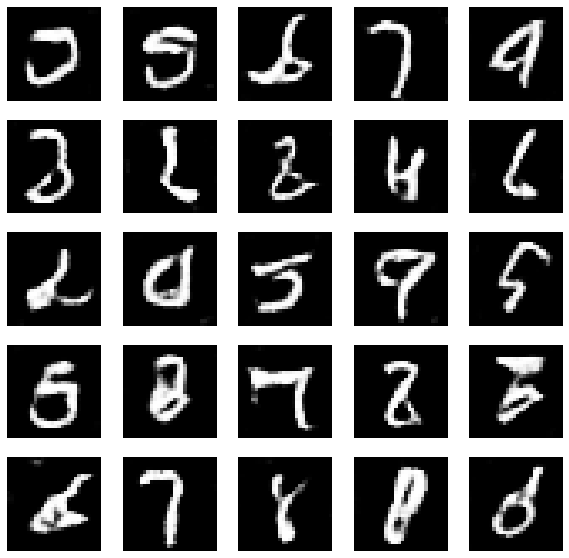

In [ ]:
X, _ = generate_fake_samples(generator, latent_dim, 25)
X = (X + 1) / 2.0

fig = plt.figure(figsize=(10, 10))

for i in range(5 * 5):
  ax = fig.add_subplot(5, 5, i+1)
  ax.axis('off')
  ax.imshow(X[i, :, :, 0], cmap=plt.cm.gray)

Pretty good results. Let's now test our WGAN on the Fashion MNIST dataset. The Only thing we need to change is the "load_dataset" dataset name that we passed into the "load_dataset" function. We are going to type "fashion_mnist". 

In [ ]:
latent_dim = 50

critic = create_crit()
generator = create_gen(latent_dim)

gan_model = create_gan(generator, critic)

dataset = load_dataset(fashion_mnist)

train(generator, critic, gan_model, dataset, latent_dim)

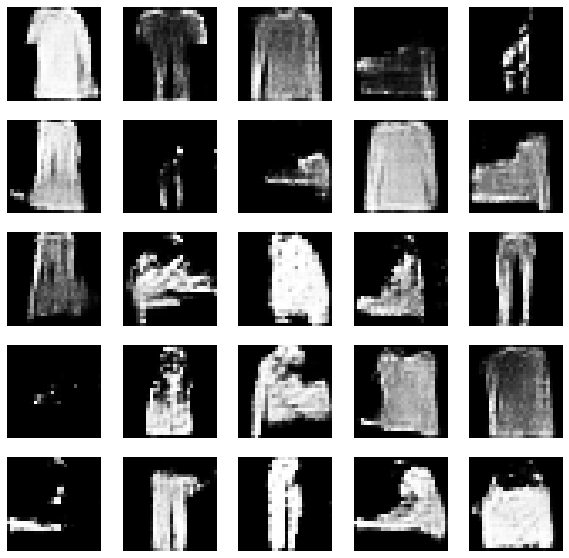

In [ ]:
X, _ = generate_fake_samples(generator, latent_dim, 25)
X = (X + 1) / 2.0

fig = plt.figure(figsize=(10, 10))

for i in range(5 * 5):
  ax = fig.add_subplot(5, 5, i+1)
  ax.axis('off')
  ax.imshow(X[i, :, :, 0], cmap=plt.cm.gray)